In [87]:
# Libraries 
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from collections import defaultdict
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [88]:
# Load the training dataset
train_data = pd.read_csv('archive/sign_mnist_train.csv')
# Load the testing dataset
test_data = pd.read_csv('archive/sign_mnist_test.csv')

In [89]:
# Separate the data (features) and the classes
X_train = train_data.drop(["label"], axis=1)  # Features (all columns except the first one)
X_train = X_train / 255.0
y_train = train_data['label']   # Target (first column)

# Separate the data (features) and the classes
X_test = test_data.drop(['label'], axis=1)  # Features (all columns except the first one)
X_test = X_test / 255.0
y_test = test_data['label']   # Target (first column)

# Create validation dataset by splitting training data (20% for validation)
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


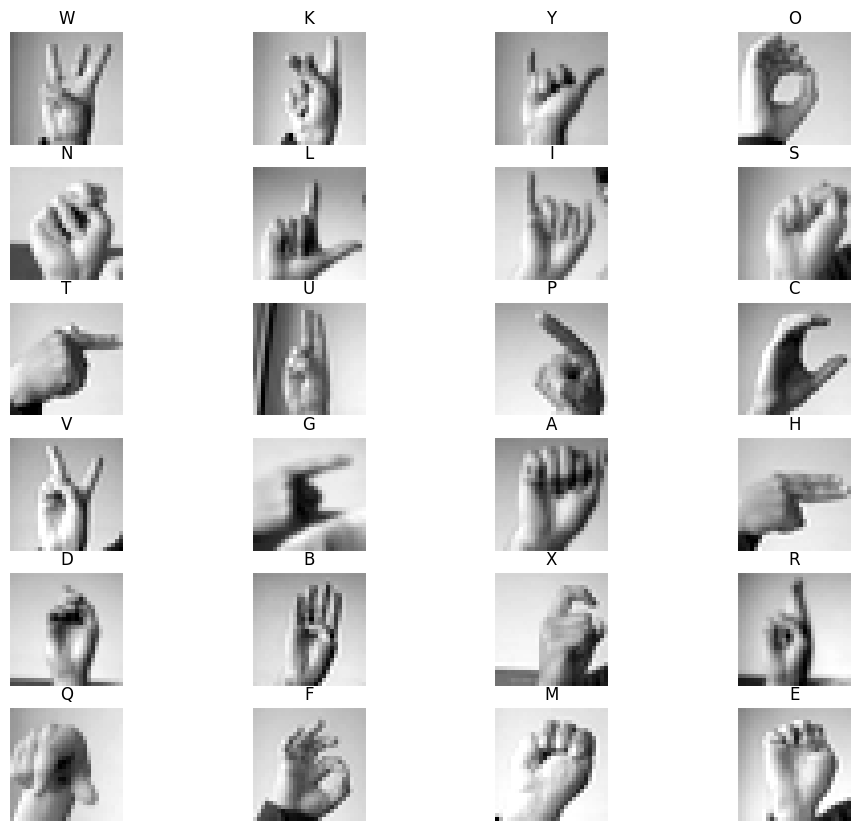

In [90]:

def show_image_by_condition( pixels, labels, label_condition=None, numbers=24, img_size=28):
    """
        Show images by label
    """
    label_to_letter = {i: chr(65 + i) for i in range(26)}

    pixels_tmp = pixels.reshape(-1, img_size, img_size, 1)
    plt.figure(figsize=(12, 12))

    cnt = 0
    if label_condition is None:
        label_condition_set = set(np.unique(labels))
    else:
        label_condition_set = set(label_condition)


    n_images = len(pixels)
    n_condition = len(label_condition_set)
    cached_label = set()
    while cnt < numbers:
        idx = np.random.randint(0, n_images)
        if labels[idx] in label_condition_set and (labels[idx] not in cached_label or cnt >= n_condition):
            cnt += 1
            cached_label.add(labels[idx])
            plt.subplot(numbers // 4 + 1, 4, cnt)
            plt.axis('off')
            plt.title(label_to_letter[labels[idx]])
            plt.imshow(pixels_tmp[idx, :, :, 0], cmap='gray')

    plt.show()
    
show_image_by_condition(X_train.to_numpy(), y_train.to_numpy() , numbers=24)

In [91]:
# Create neural network with different hidden layer size (changed from 8 to 64 neurons)
neural_net_model = MLPClassifier(hidden_layer_sizes=(64), random_state=42, tol=0.005, max_iter=1000)
# Start the training
neural_net_model.fit(X_train, y_train)


,hidden_layer_sizes,64
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,1000
,shuffle,True
,random_state,42


In [92]:
# Determine model architecture 
layer_sizes = [neural_net_model.coefs_[0].shape[0]]  # Start with the input layer size
layer_sizes += [coef.shape[1] for coef in neural_net_model.coefs_]  # Add sizes of subsequent layers
layer_size_str = " x ".join(map(str, layer_sizes))
print(f"Training set size: {len(y_train)}")
print(f"Validation set size: {len(y_validate)}")
print(f"Test set size: {len(y_test)}")
print(f"Layer sizes: {layer_size_str}")

# Predict on all datasets
y_pred_train = neural_net_model.predict(X_train)
y_pred_validate = neural_net_model.predict(X_validate)
y_pred_test = neural_net_model.predict(X_test)

# Calculate accuracies
train_accuracy = accuracy_score(y_pred_train, y_train)* 100
validate_accuracy = accuracy_score(y_pred_validate, y_validate)* 100
test_accuracy = accuracy_score(y_pred_test, y_test)* 100

print(f"----------")
print(f"Training Accuracy: {train_accuracy:.1f}%")
print(f"Validation Accuracy: {validate_accuracy:.1f}%")
print(f"Test Accuracy: {test_accuracy:.1f}%")

Training set size: 21964
Validation set size: 5491
Test set size: 7172
Layer sizes: 784 x 64 x 24
----------
Training Accuracy: 99.9%
Validation Accuracy: 99.8%
Test Accuracy: 70.9%


In [93]:
# Create dictionaries to hold counts
correct_counts = defaultdict(int) # number of times the model predicted this class correctly
total_counts = defaultdict(int) # total number of test samples belonging to this class

# Count correct predictions and total predictions for each class
for true, pred in zip(y_test, y_pred_test):
    total_counts[true] += 1
    if true == pred:
        correct_counts[true] += 1 

# Calculate and print accuracy for each class
print(f"----------")
print("Per-class Test Accuracies:")
for class_id in sorted(total_counts.keys()):
    accuracy = correct_counts[class_id] / total_counts[class_id] * 100
    print(f"Class {class_id}: {accuracy:3.0f}%")

----------
Per-class Test Accuracies:
Class 0: 100%
Class 1:  88%
Class 2:  92%
Class 3:  76%
Class 4:  87%
Class 5:  90%
Class 6:  77%
Class 7:  75%
Class 8:  76%
Class 10:  43%
Class 11:  86%
Class 12:  57%
Class 13:  43%
Class 14:  63%
Class 15:  96%
Class 16:  74%
Class 17:  67%
Class 18:  41%
Class 19:  56%
Class 20:  47%
Class 21:  48%
Class 22:  87%
Class 23:  61%
Class 24:  54%


In [94]:
# Generate confusion matrix to find most misidentified classes
conf_matrix = confusion_matrix(y_test, y_pred_test)
class_labels = sorted(list(set(y_test)))

# Calculate misidentification rates for each class
misidentification_rates = {}
for i, true_class in enumerate(class_labels):
    total_true = np.sum(conf_matrix[i, :])
    correct = conf_matrix[i, i]
    misidentified = total_true - correct
    misidentification_rate = (misidentified / total_true) * 100 if total_true > 0 else 0
    misidentification_rates[true_class] = misidentification_rate

# Find the 3 most misidentified classes
most_misidentified = sorted(misidentification_rates.items(), key=lambda x: x[1], reverse=True)[:3]

print(f"----------")
print("Most Misidentified Classes (letters):")
for class_id, rate in most_misidentified:
    print(f"Class {class_id}: {rate:.1f}% misidentification rate")


----------
Most Misidentified Classes (letters):
Class 18: 58.5% misidentification rate
Class 10: 56.8% misidentification rate
Class 13: 56.7% misidentification rate


In [95]:

# Show what these misidentified classes are most often confused with
print(f"----------")
print("Common Misidentifications:")
for class_id, rate in most_misidentified:
    class_idx = class_labels.index(class_id)
    # Get the row for this class from confusion matrix
    row = conf_matrix[class_idx, :]
    # Set the correct prediction to 0 to find top misclassifications
    row_copy = row.copy()
    row_copy[class_idx] = 0
    # Find top 2 misclassifications
    top_mistakes = np.argsort(row_copy)[-2:][::-1]
    
    if row_copy[top_mistakes[0]] > 0:
        print(f"Class {class_id} most often confused with: ", end="")
        mistake_classes = []
        for mistake_idx in top_mistakes:
            if row_copy[mistake_idx] > 0:
                mistake_class = class_labels[mistake_idx]
                count = row_copy[mistake_idx]
                mistake_classes.append(f"Class {mistake_class} ({count} times)")
        print(", ".join(mistake_classes[:2]))



----------
Common Misidentifications:
Class 18 most often confused with: Class 8 (42 times), Class 12 (41 times)
Class 10 most often confused with: Class 17 (64 times), Class 15 (34 times)
Class 13 most often confused with: Class 0 (42 times), Class 18 (41 times)


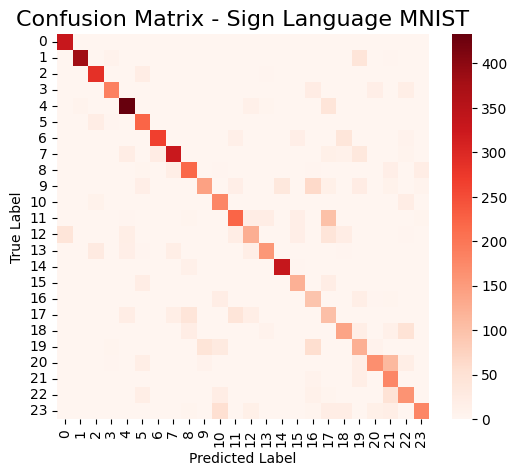

In [96]:
# Confusion matrix heatmap 
# Shows how often each class is predicted as each other class
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=False, cmap="Reds")
plt.title("Confusion Matrix - Sign Language MNIST", fontsize=16)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [97]:
# Classification report for detailed precision, recall, f1-score
print("----------")
print("Classification Report:")
print(classification_report(y_test, y_pred_test))

# Precision -->	Of all samples the model predicted as class X, how many were correct?
# Recall -->	Of all samples that truly belong to class X, how many did the model identify correctly?
# F1-score -->	Harmonic mean of precision and recall, gives a balanced measure of model performance on class X 
# Support -->	Number of true instances for each class in the test set

# macro avg: average metrics across all classes, treating each class equally
# weighted avg: average metrics across all classes, weighted by number of instances per class

----------
Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       331
           1       0.98      0.88      0.93       432
           2       0.83      0.92      0.87       310
           3       0.93      0.76      0.84       245
           4       0.84      0.87      0.86       498
           5       0.67      0.90      0.77       247
           6       0.92      0.77      0.84       348
           7       0.85      0.75      0.80       436
           8       0.72      0.76      0.74       288
          10       0.74      0.43      0.55       331
          11       0.58      0.86      0.69       209
          12       0.70      0.57      0.62       394
          13       0.59      0.43      0.50       291
          14       0.82      0.63      0.71       246
          15       0.91      0.96      0.93       347
          16       0.69      0.74      0.71       164
          17       0.36      0.67      0.47    

In [ ]:
import cv2
import numpy as np

def preprocess_image_for_model(path):
    # Load image
    img = cv2.imread(path)
    if img is None:
        raise ValueError("Image not found or path incorrect")

    # Convert to grayscale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Resize to 28x28 (MNIST format)
    img = cv2.resize(img, (28, 28))
    

    # Invert colors if your hand is dark and background is light
    # Comment this out if your hand is white on black
    # img = 255 - img

    # Normalize to 0..1
    img = img.astype("float32") / 255.0

    # Flatten into shape (1, 784)
    img = img.reshape(1, 784)
    


    return img

# Example:
test_img = preprocess_image_for_model("test_image.jpeg")
prediction = neural_net_model.predict(test_img)

print("Predicted label:", prediction)


Predicted label: [10]


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
